In [1]:
import torch
import torch.nn as nn
import math

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import seaborn as sns
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = np.loadtxt('./data/tower_prep_data_csv.csv', delimiter=',', dtype=np.float32, skiprows=1)

In [3]:
temperature = data[:, 3]
print(temperature)

[13.345  0.48   0.53  ... 14.98  16.8   26.21 ]


In [4]:
size = 15000 #math.ceil(len(temperature) * 0.8)
train_data = temperature[: -size]
test_data = temperature[-size :]

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

In [6]:
train_window = 60

In [7]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [8]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [9]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=20, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, 1)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [11]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

[7.25907564]


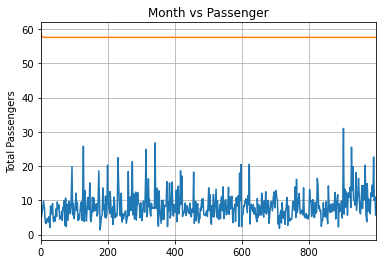

In [12]:
for i in range(1):

    #train_window = 20000 - i * 1000
    fut_pred = 1000

    test_inputs = train_data_normalized[-train_window:].tolist()

    model.eval()

    for i in range(fut_pred):
        seq = torch.FloatTensor(test_inputs[-train_window:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            test_inputs.append(model(seq).item())




    actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
    #print(actual_predictions)

    sum = 0
    for i in range(fut_pred):

        sum += abs(actual_predictions[i] - test_data[i]) / test_data[i]

    accuracy = sum / fut_pred
    print(accuracy)
    
    plt.title('Month vs Passenger')
    plt.ylabel('Total Passengers')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(test_data[:fut_pred])
    plt.plot(actual_predictions)
    plt.show()

epoch:   0 loss: 0.00041922
epoch:   1 loss: 0.00050034
epoch:   2 loss: 0.00061101
epoch:   3 loss: 0.00073326
epoch:   4 loss: 0.00080791
epoch:   4 loss: 0.0008079150
[0.39041139]


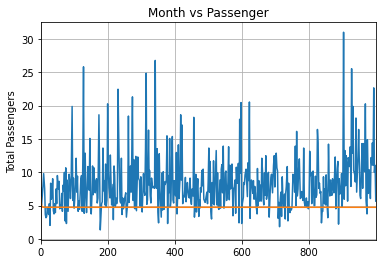

In [14]:
epochs = 5
accuracy = 1

while(accuracy > 0.5):
    for i in range(epochs):
        for seq, labels in train_inout_seq:

            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))

            y_pred = model(seq)

            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()

        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    
    

    fut_pred = 1000

    test_inputs = train_data_normalized[-train_window:].tolist()

    model.eval()

    for i in range(fut_pred):
        seq = torch.FloatTensor(test_inputs[-train_window:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
            test_inputs.append(model(seq).item())




    actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
    #print(actual_predictions)

    sum = 0
    for i in range(fut_pred):

        sum += abs(actual_predictions[i] - test_data[i]) / test_data[i]

    accuracy = sum / fut_pred
    print(accuracy)
    
    plt.title('Month vs Passenger')
    plt.ylabel('Total Passengers')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(test_data[:fut_pred])
    plt.plot(actual_predictions)
    plt.show()


In [29]:
torch.save(model, "./models/vibrations.pt")